<h1>Обучение модели обнаружения аномалий на сигнале DPIT301</h1>

In [1]:
import numpy as np
np.set_printoptions(threshold=np.inf)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import optimizers


dir = os.getcwd()
import time
from pickle import load, dump

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

import winsound
from datetime import datetime
from rnn_training import *
from cf_matrix import *
from VAD import VAD

from scipy.signal import medfilt, wiener
import math

<h2>Импорт и отображение данных</h2>

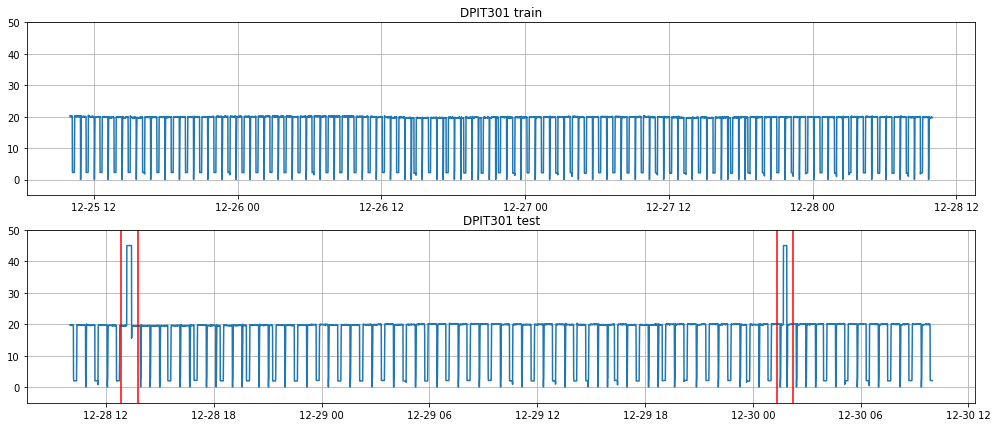

In [12]:
train_dataframe = pd.read_csv("Train.csv", usecols=[2])
train_dateindex = pd.date_range("2015-12-25 10:00:00", 
                                periods=train_dataframe.shape[0], freq="s")
train_dataframe.index = train_dateindex

test_dataframe = pd.read_csv("Test.csv", usecols=[3,4])
test_dateindex = pd.date_range("2015-12-28 10:00:00",
                               periods=test_dataframe.shape[0], freq="s")
test_dataframe.index = test_dateindex

train_dataframe = train_dataframe.resample('30s').first()
test_dataframe = test_dataframe.resample('30S').first()

anomal_dateindex =  pd.to_datetime(["28.12.2015 13:09:45", "28.12.2015 13:25:54",
                                    "30.12.2015 01:42:07", "30.12.2015 01:53:30"])

redline_dateindex =  pd.to_datetime(["28.12.2015 12:49:45", "28.12.2015 13:45:54",
                                     "30.12.2015 01:22:07", "30.12.2015 02:13:30"])
  

minimum = min(train_dataframe['DPIT301'].min(), test_dataframe['DPIT301'].min())
maximum = max(train_dataframe['DPIT301'].max(), test_dataframe['DPIT301'].max())


plt.figure(figsize=(17, 7))

plt.subplot(211)
plt.plot(train_dataframe['DPIT301'])
plt.title('DPIT301 train')
plt.ylim(minimum-5,maximum+5)
plt.grid()

plt.subplot(212)
plt.plot(test_dataframe['DPIT301'])
for ind in redline_dateindex:
    plt.axvline(x=ind,color='r')
plt.title('DPIT301 test')
plt.ylim(minimum-5,maximum+5)
plt.grid()
plt.savefig('Models//DPIT301//DPIT301 train&test', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

<h2>Приведение данных к масштабу [0,1]
и отображение масштабированных данных</h2>

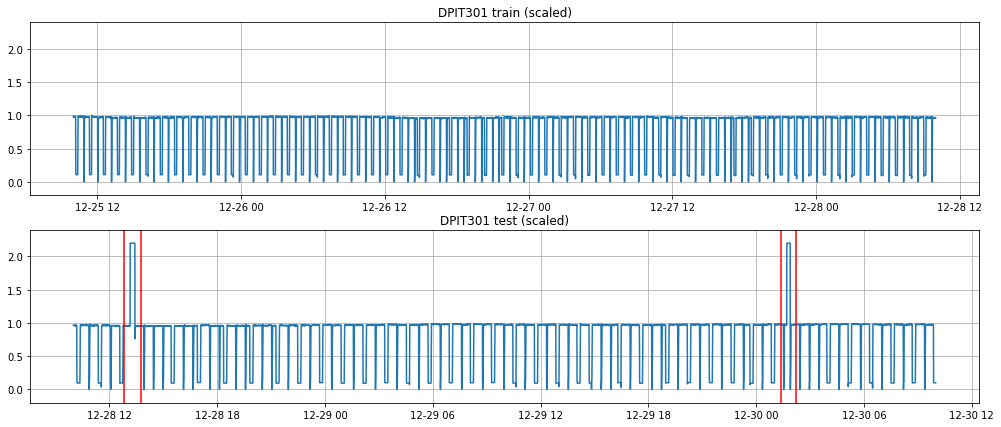

In [13]:
scaler = MinMaxScaler()
scaler.fit(train_dataframe)

train_dataframe = pd.DataFrame(data = scaler.transform(train_dataframe),
                               columns=train_dataframe.columns,
                               index = train_dataframe.index)
test_dataframe = pd.DataFrame(data = np.concatenate((scaler.transform(test_dataframe['DPIT301'].to_frame()),
                                                     test_dataframe['DPIT301_label'].to_numpy()[:,np.newaxis]),
                                                    axis=1),
                              index = test_dataframe.index,
                              columns = test_dataframe.columns)


minimum = min(train_dataframe['DPIT301'].min(), test_dataframe['DPIT301'].min())
maximum = max(train_dataframe['DPIT301'].max(), test_dataframe['DPIT301'].max())

plt.figure(figsize=(17, 7))

plt.subplot(211)
plt.plot(train_dataframe['DPIT301'])
plt.title('DPIT301 train (scaled)')
plt.ylim(minimum-0.2,maximum+0.2)
plt.grid()

plt.subplot(212)
plt.plot(test_dataframe['DPIT301'])
for ind in redline_dateindex:
    plt.axvline(x=ind,color='r')
plt.title('DPIT301 test (scaled)')
plt.ylim(minimum-0.2,maximum+0.2)
plt.grid()
plt.savefig('Models//DPIT301//DPIT301 train&test scaled', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

<h2>Создание обучающих, валидационных и тестовых данных</h2>

In [4]:
train_X = train_dataframe['DPIT301'][:-2880].to_numpy()[:,np.newaxis]
train_Y = train_X.copy()
train_data = np.concatenate((train_X, train_Y), axis=1).astype(np.float32)

valid_X = train_dataframe['DPIT301'][-2880:].to_numpy()[:,np.newaxis]
valid_Y = valid_X.copy()
valid_data = np.concatenate((valid_X, valid_Y), axis=1).astype(np.float32)

test_X = test_dataframe['DPIT301'].to_numpy()[:,np.newaxis]
test_Y = test_X.copy()
test_data = np.concatenate((test_X, test_Y), axis=1).astype(np.float32)

<h2>Задание параметров обучения, инициализация и обучение модели</h2>

In [5]:
num_neurons = 20
opt = optimizers.SGD()
loss = 'mean_squared_error'
num_epochs = 200

In [6]:
model, train_loss, val_loss, epochs, train_time = create_model(train_data = train_data, batch_size = 1,
                                                               neurons = num_neurons, opt = opt, loss_func = loss, out_dim = 1)

The training was completed in 0h 18m 57s (5.69 sec/epoch).


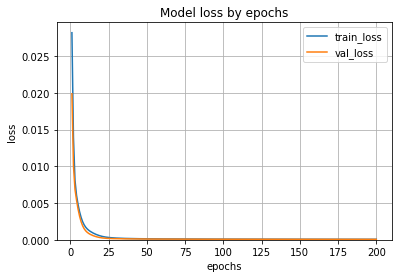

In [7]:
model, train_loss, val_loss, epochs, train_time = fit_rnn(model = model, train_data = train_data, val_data = valid_data,
                                                          nb_epoch = num_epochs, batch_size = 1,
                                                          train_loss = train_loss, val_loss = val_loss,
                                                          epochs = epochs, train_time = train_time, out_dim = 1)

<h2>Получение отклика модели на обучающих, валидационных и тестовых данных</h2>

In [8]:
predictions_train = np.zeros(shape = (len(train_data), 1))
for i in range(len(train_data)):
    X = train_data[i, 0:-1]
    yhat = forecast_rnn(model = model, batch_size = 1, X = X)
    predictions_train[i] = yhat
    
predictions_valid = np.zeros(shape = (len(valid_data), 1))
for i in range(len(valid_data)):
    X = valid_data[i, 0:-1]
    yhat = forecast_rnn(model = model, batch_size = 1, X = X)
    predictions_valid[i] = yhat
    
predictions_test = np.zeros(shape = (len(test_data), 1))
for i in range(len(test_data)):
    X = test_data[i, 0:-1]
    yhat = forecast_rnn(model = model, batch_size = 1, X = X)
    predictions_test[i] = yhat

<h2>Сохранение модели и откликов</h2>

In [13]:
model_directory = str(dir) + '\\Models\\DPIT301'
now_date = str(datetime.now().strftime("%Y-%m-%d_%H-%M"))

model.save(model_directory+'\\model_'+now_date)

with open(model_directory+'\\model_'+now_date+'\\train.predict', 'wb') as f:
    dump(predictions_train, f)
with open(model_directory+'\\model_'+now_date+'\\valid.predict', 'wb') as f:
    dump(predictions_valid, f)
with open(model_directory+'\\model_'+now_date+'\\test.predict', 'wb') as f:
    dump(predictions_test, f)

INFO:tensorflow:Assets written to: C:\Users\skolp\YandexDisk\УЧЕБА\ДИПЛОМ\SWaT\SWat A1\Models\DPIT301\model_2021-05-25_14-23\assets


INFO:tensorflow:Assets written to: C:\Users\skolp\YandexDisk\УЧЕБА\ДИПЛОМ\SWaT\SWat A1\Models\DPIT301\model_2021-05-25_14-23\assets


<h2>Загрузка модели и откликов</h2>

In [5]:
model_directory = str(dir) + '\\Models\\DPIT301'
model_input = input('Папка с моделью:')
model = load_model(model_directory+'\\'+model_input)
with open(model_directory+'\\'+model_input+'\\train.predict', 'rb') as f:
    predictions_train = load(f)
with open(model_directory+'\\'+model_input+'\\valid.predict', 'rb') as f:
    predictions_valid = load(f)
with open(model_directory+'\\'+model_input+'\\test.predict', 'rb') as f:
    predictions_test = load(f)
print('Модель и отклики загружены')

Папка с моделью:model_2021-05-25_14-23
Модель и отклики загружены


<h2>Отображение обучающих данных, отклика модели и ошибки отклика</h2>

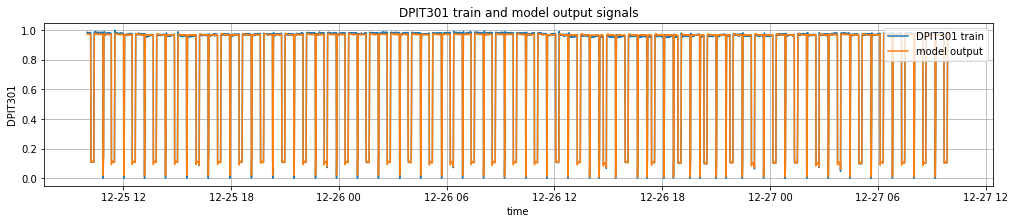

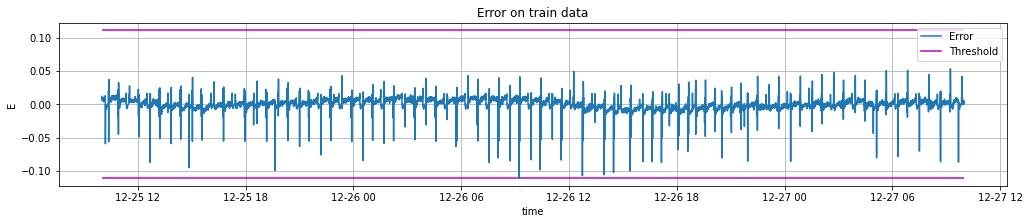

In [6]:
#Train plot
# line plot of observed vs predicted
plt.figure(figsize=(17, 3))
plt.plot(train_dataframe.index[:-2880], train_data[:, 0])
plt.plot(train_dataframe.index[:-2880], predictions_train[:, 0])
plt.title('DPIT301 train and model output signals')
plt.ylabel('DPIT301')
plt.xlabel('time')
plt.grid()
plt.legend(('DPIT301 train','model output'), loc=1)
plt.savefig(model_directory+'\\'+model_input+'\\train+model', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

error_train = train_data[:, -1] - predictions_train[:, 0]
anomal_threshhold = max(abs(error_train[10:]))

plt.figure(figsize=(17, 3))
plt.plot(train_dataframe.index[:-2880], error_train)
plt.hlines(anomal_threshhold, train_dataframe.index[0],
           train_dataframe.index[-2880], colors = 'm')
plt.hlines(-anomal_threshhold, train_dataframe.index[0],
           train_dataframe.index[-2880], colors = 'm')
plt.title('Error on train data')
plt.ylabel('E')
plt.xlabel('time')
plt.grid()
legend_elements = [Line2D([0], [0], color='tab:blue', label='Error'),
                   Line2D([0], [0], color='m', label='Threshold')]
plt.legend(handles=legend_elements, loc=1)
plt.savefig(model_directory+'\\'+model_input+'\\train error', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

<h2>Отображение валидационных данных, отклика модели и ошибки отклика</h2>

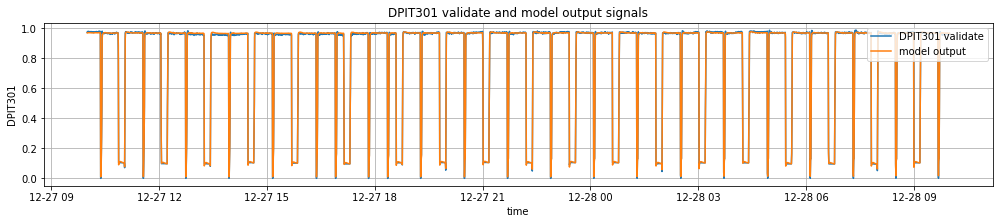

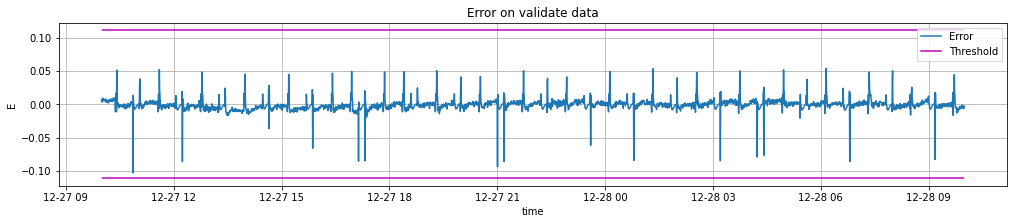

In [7]:
#Validate plot
# line plot of observed vs predicted
plt.figure(figsize=(17,3))
plt.plot(train_dataframe.index[-2880:], valid_data[:, 0])
plt.plot(train_dataframe.index[-2880:], predictions_valid[:, 0])
plt.title('DPIT301 validate and model output signals')
plt.ylabel('DPIT301')
plt.xlabel('time')
plt.grid()
plt.legend(('DPIT301 validate','model output'), loc=1)
plt.savefig(model_directory+'\\'+model_input+'\\valid+model', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

error_valid = valid_data[:, -1] - predictions_valid[:, 0]
plt.figure(figsize=(17,3))
plt.plot(train_dataframe.index[-2880:], error_valid)
plt.hlines(anomal_threshhold, train_dataframe.index[-2880],
           train_dataframe.index[-1],colors = 'm')
plt.hlines(-anomal_threshhold, train_dataframe.index[-2880],
           train_dataframe.index[-1],colors = 'm')
plt.title('Error on validate data')
plt.ylabel('E')
plt.xlabel('time')
plt.grid()
legend_elements = [Line2D([0], [0], color='tab:blue', label='Error'),
                   Line2D([0], [0], color='m', label='Threshold')]
plt.legend(handles=legend_elements, loc=1)
plt.savefig(model_directory+'\\'+model_input+'\\valid error', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

<h2>Отображение тестовых данных, отклика модели и ошибки отклика</h2>

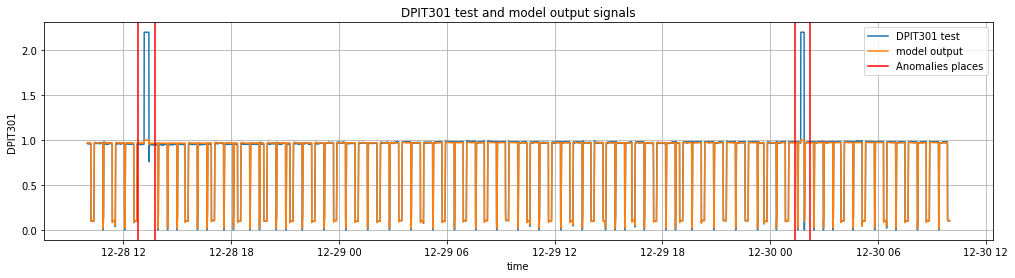

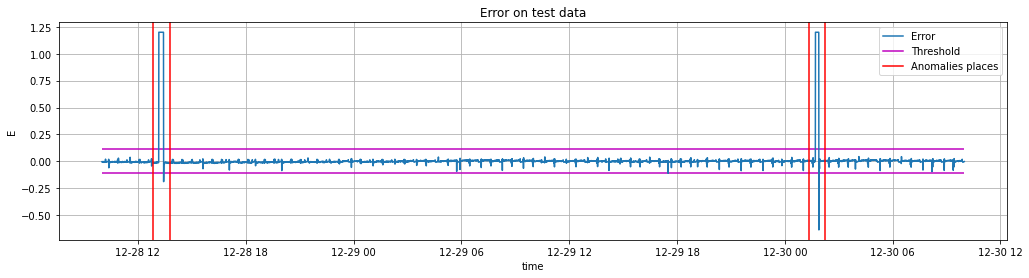

In [8]:
#Test plot
# line plot of observed vs predicted
plt.figure(figsize=(17,4))
plt.plot(test_dataframe.index, test_data[:, 0])
plt.plot(test_dataframe.index, predictions_test[:, 0])
for ind in redline_dateindex:
    plt.axvline(x=ind,color='r')
plt.title('DPIT301 test and model output signals')
plt.ylabel('DPIT301')
plt.xlabel('time')
plt.grid()
legend_elements = [Line2D([0], [0], color='tab:blue', label='DPIT301 test'),
                   Line2D([0], [0], color='tab:orange', label='model output'),
                   Line2D([0], [0], color='r', label='Anomalies places')]
plt.legend(handles=legend_elements, loc=1)
plt.savefig(model_directory+'\\'+model_input+'\\test+model', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

error_test = test_data[:, -1] - predictions_test[:, 0]
plt.figure(figsize=(17,4))
plt.plot(test_dataframe.index, error_test)
for ind in redline_dateindex:
    plt.axvline(x=ind,color='r')
plt.hlines(anomal_threshhold, test_dataframe.index[0],
           test_dataframe.index[-1], colors = 'm', label='threshhold')
plt.hlines(-anomal_threshhold, test_dataframe.index[0],
           test_dataframe.index[-1], colors = 'm', label='threshhold')
plt.title('Error on test data')
plt.ylabel('E')
plt.xlabel('time')
plt.grid()
legend_elements = [Line2D([0], [0], color='tab:blue', label='Error'),
                   Line2D([0], [0], color='m', label='Threshold'),
                   Line2D([0], [0], color='r', label='Anomalies places')]
plt.legend(handles=legend_elements, loc=1)
plt.savefig(model_directory+'\\'+model_input+'\\test error', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

<h2>Метрики качества модели</h2>

              precision    recall  f1-score   support

      Anomal       0.95      1.00      0.97        55
      Normal       1.00      1.00      1.00      5705

    accuracy                           1.00      5760
   macro avg       0.97      1.00      0.99      5760
weighted avg       1.00      1.00      1.00      5760



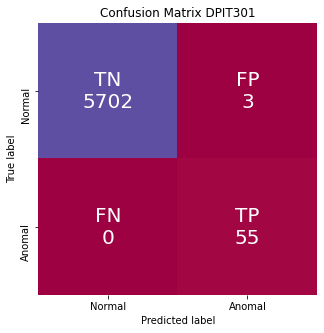

In [9]:
true_labels = test_dataframe['DPIT301_label'].to_numpy()
model_labels = list()
for e in error_test:
    if abs(e) > anomal_threshhold:
        model_labels.append('Anomal')
    else:
        model_labels.append('Normal')
model_labels = np.array(model_labels)

cf_matrix = confusion_matrix(true_labels, model_labels, labels = ['Normal','Anomal'])
make_confusion_matrix(cf_matrix,
                      f_name = model_directory+'\\'+model_input+'\\conf matrix',
                      group_names = ['TN','FP','FN','TP'],
                      categories = ['Normal', 'Anomal'],
                      percent = False,
                      cbar = False,
                      sum_stats = False,
                      cmap = 'Spectral',
                      figsize = (5,5),
                      title = 'Confusion Matrix DPIT301')
print(classification_report(true_labels, model_labels))

## Применение Voice activity detection для аномальных отрезков по сигналу ошибки

In [10]:
test_signal, detection = VAD(signal=error_test, norma=error_train, frame_len = 10, k_th = 1)

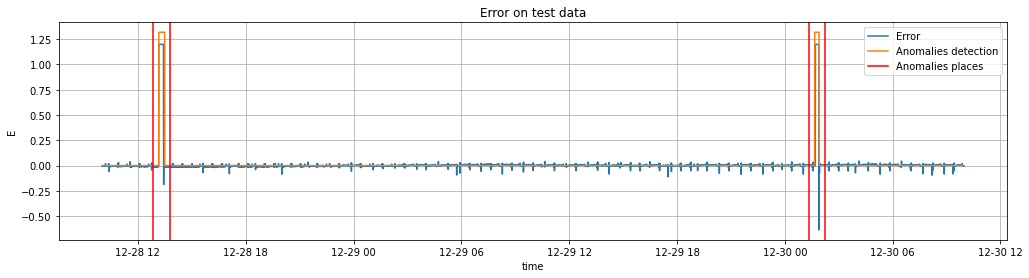

              precision    recall  f1-score   support

      Anomal       0.79      1.00      0.88        55
      Normal       1.00      1.00      1.00      5705

    accuracy                           1.00      5760
   macro avg       0.89      1.00      0.94      5760
weighted avg       1.00      1.00      1.00      5760



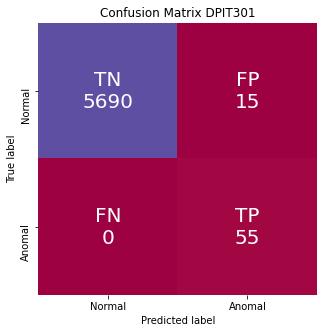

In [11]:
plt.figure(figsize=(17,4))
plt.plot(test_dataframe.index[:len(test_signal)], test_signal)
plt.plot(test_dataframe.index[:len(test_signal)], detection)
for ind in redline_dateindex:
    plt.axvline(x=ind,color='r')
plt.title('Error on test data')
plt.ylabel('E')
plt.xlabel('time')
plt.grid()
legend_elements = [Line2D([0], [0], color='tab:blue', label='Error'),
                   Line2D([0], [0], color='tab:orange', label='Anomalies detection'),
                   Line2D([0], [0], color='r', label='Anomalies places')]
plt.legend(handles=legend_elements, loc=1)
plt.savefig(model_directory+'\\'+model_input+'\\test error VAD', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

true_labels = test_dataframe['DPIT301_label'].to_numpy()[:len(test_signal)]
model_labels = list()
for d in detection:
    if d != 0:
        model_labels.append('Anomal')
    else:
        model_labels.append('Normal')
model_labels = np.array(model_labels)

cf_matrix = confusion_matrix(true_labels, model_labels, labels = ['Normal','Anomal'])
make_confusion_matrix(cf_matrix,
                      f_name = model_directory+'\\'+model_input+'\\conf matrix VAD',
                      group_names = ['TN','FP','FN','TP'],
                      categories = ['Normal', 'Anomal'],
                      percent = False,
                      cbar = False,
                      sum_stats = False,
                      cmap = 'Spectral',
                      figsize = (5,5),
                      title = 'Confusion Matrix DPIT301')
print(classification_report(true_labels, model_labels))